In [1]:
import numpy as np
import os
from   pathlib import Path

np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets
Datasets
- [MNIST](http://www-labs.iro.umontreal.ca/~lisa/deep/data/mnist/): 28x28 GrayScale
- [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html): 32x32x3 RGB

Data Preparation
- shuffle orignal training set
- Training set (size=first 10K), Validation Set (size=second 10k discard remaining), Test set (size=10k) as is

In [2]:
data_dir     = Path('./data')
exports_dir  = Path('./exports')
model_dir    = Path('./models')
mnist_url    = "http://www-labs.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz"
cifar100_url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

In [3]:
# creat directories
if not data_dir.exists():    data_dir.mkdir()
if not exports_dir.exists(): exports_dir.mkdir()

# ETL / Data Preparation

In [4]:
import hunter.core.system.downloader  as hcdld
import hunter.core.system.reader      as hcrd
import hunter.core.datasets.partition as hcpart

In [5]:
def get_mnist(data_root_dir:str, url:str, force_dwld:bool=False, partition_size:int=10000):
    "process mnist data"
    # mnist: download, extract, and read files
    # disregard validation data to create new validation set 
    hcdld.download(url, data_root_dir, force_dwld=force_dwld)
    train, valid, test = hcrd.load_pkl_gzip(data_root_dir/Path(url).name)
    X_test, y_test     = test
    # shuffle original training dataset (X,y) in unison
    X_train_shf, y_train_shf = hcpart.shuffle_partition(*train)
    # partition: disregard validation data to create new validation set 
    train_size = valid_size = test_size = partition_size    
    X_train, X_valid, y_train, y_valid  = hcpart.repartition(X_train_shf, y_train_shf, train_size, valid_size)
    # based on this url, the mnist dataset is already scaled, so no reason to scale (x/255) the data       
    return (X_train, X_valid, X_test, y_train, y_valid, y_test)    

X_train_mnist, X_valid_mnist, X_test_mnist, y_train_mnist, y_valid_mnist, y_test_mnist = get_mnist(data_dir, mnist_url, True)
print(X_train_mnist.shape, X_valid_mnist.shape, X_test_mnist.shape)
print(y_train_mnist.shape, y_valid_mnist.shape, y_test_mnist.shape)

Source: data/mnist.pkl.gz, # Bytes downloaded: 16168813, # Bytes Expected 16168813
downloaded Source: data/mnist.pkl.gz
(10000, 784) (10000, 784) (10000, 784)
(10000,) (10000,) (10000,)


In [6]:
def get_cifar(data_root_dir:str, url:str, force_dwld:bool=False, partition_size:int=10000):
    "process cifar100 data"
    # cifar: download, extract, and read files
    hcdld.download(url, data_root_dir, force_dwld=force_dwld)
    hcdld.file_extract(str(data_root_dir/Path(url).name), data_root_dir)
    # remove extensions for folder name
    fname = Path(cifar100_url).name
    ext   = "".join(Path(fname).suffixes)
    fname = fname.replace(ext, '')
    # extract information
    meta, train, test = [hcrd.load_pickle(os.path.join(data_root_dir/fname, part)) for part in ['meta', 'train', 'test']]
    # shuffle original training dataset (X,y) in unison
    label_names = [t.decode('utf8') for t in meta[b'fine_label_names']]
    X_train, y_train = np.array(train[b'data'].astype(np.float64)), np.array(train[b'fine_labels'])
    X_train_shf, y_train_shf = hcpart.shuffle_partition(X_train, y_train)
    # Scale data, idealing we would scale the trainingn data statistics and use that to tranform (Val, Test)
    X_train_shf /= 255.
    # partition: disregard validation data to create new validation set 
    train_size = valid_size = test_size = partition_size    
    X_train, X_valid, y_train, y_valid  = hcpart.repartition(X_train_shf, y_train_shf, train_size, valid_size)    
    # extract test set and scale it
    X_test,  y_test  = np.array(test[b'data'].astype(np.float64)),  np.array(test[b'fine_labels'])
    X_test /= 255.    
    return (X_train, X_valid, X_test, y_train, y_valid, y_test, label_names)    

    
X_train_cifar, X_valid_cifar, X_test_cifar, y_train_cifar, y_valid_cifar, y_test_cifar, label_names_cifar = \
get_cifar(data_dir, cifar100_url, force_dwld=True)  
print(X_train_cifar.shape, X_valid_cifar.shape, X_test_cifar.shape)
print(y_train_cifar.shape, y_valid_cifar.shape, y_test_cifar.shape)

Source: data/cifar-100-python.tar.gz, # Bytes downloaded: 169001437, # Bytes Expected 169001437
downloaded Source: data/cifar-100-python.tar.gz
(10000, 3072) (10000, 3072) (10000, 3072)
(10000,) (10000,) (10000,)


# EDA
- Visualize for correctness with given plots in pdf
- Bin [0-255] valuesin a histogram
- Apply Seaborn KDE on top

In [7]:
import hunter.core.visual.plots as hcplt

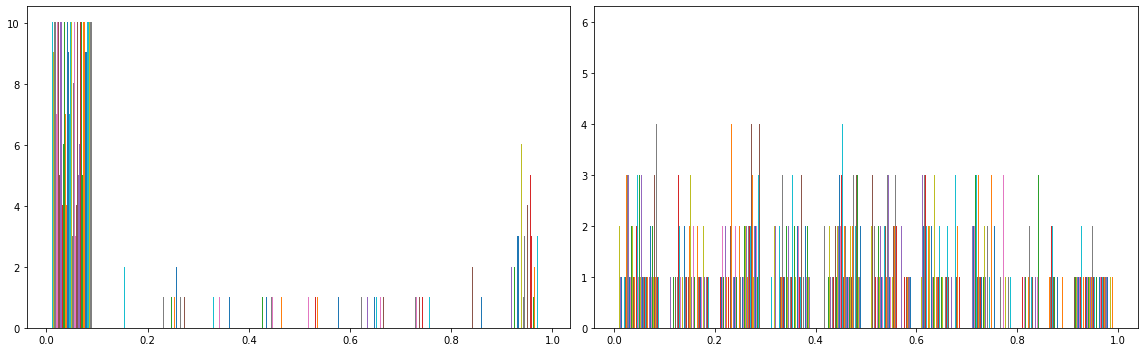

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
hist1 = ax1.hist(X_train_mnist[:10], bins=10, density=True)
hist2 = ax2.hist(X_train_cifar[:10], bins=10, density=True)
plt.tight_layout()

In [9]:
density, bins, patches = hist1
widths = bins[1:] - bins[:-1]
(density * widths).sum()

784.0

## Plot Label Distributions across each dataset

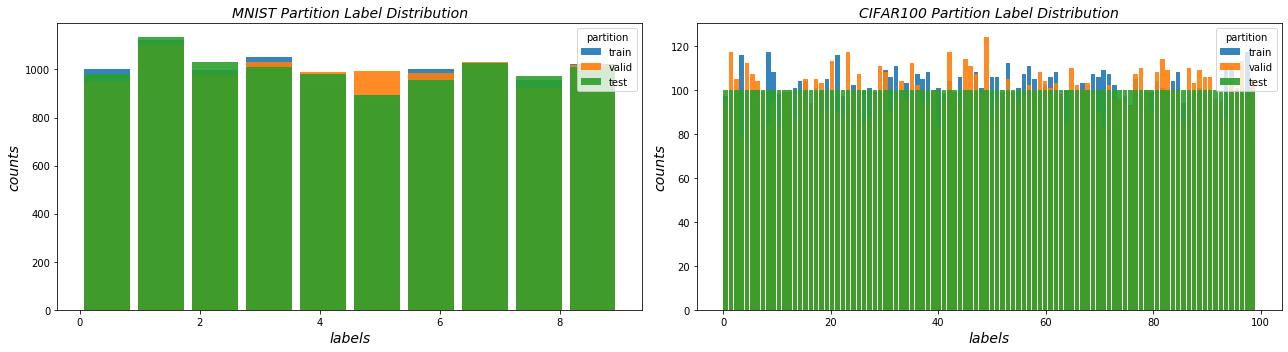

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
# plot mnist label distributions
ax1.hist(y_train_mnist, bins=len(np.unique(y_train_mnist)), alpha=0.9, rwidth=0.85, label='train')
ax1.hist(y_valid_mnist, bins=len(np.unique(y_valid_mnist)), alpha=0.9, rwidth=0.85, label='valid')
ax1.hist(y_test_mnist,  bins=len(np.unique(y_test_mnist)),  alpha=0.9, rwidth=0.85, label='test')
hcplt.set_axis_opts(ax1, **{'xaxis-label': 'labels', 'yaxis-label': 'counts', 'title': 'MNIST Partition Label Distribution'})
ax1.legend(loc='upper right', title='partition')
# plot cifar100 label distributions
ax2.hist(y_train_cifar, bins=len(np.unique(y_train_cifar)), alpha=0.9, rwidth=0.85, label='train')
ax2.hist(y_valid_cifar, bins=len(np.unique(y_valid_cifar)), alpha=0.9, rwidth=0.85, label='valid')
ax2.hist(y_test_cifar,  bins=len(np.unique(y_test_cifar)),  alpha=0.9, rwidth=0.85, label='test')
hcplt.set_axis_opts(ax2, **{'xaxis-label': 'labels', 'yaxis-label': 'counts', 'title': 'CIFAR100 Partition Label Distribution'})
ax2.legend(loc='upper right', title='partition')
plt.tight_layout()

## MNIST Matrix Image

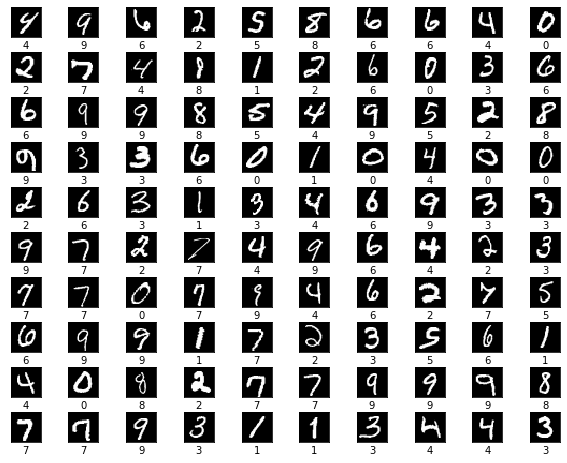

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
# reshape dense array to channel specific dimensions
h,w,ch = (28,28,1)
X_train_mnist_img = X_train_mnist.reshape(X_train_mnist.shape[0], h, w).astype(np.float64)
# plot mnist dataset partitions
label_idxs = list(map(str, np.unique(y_train_mnist)))
hcplt.plot_image_as_subplot(X_train_mnist_img, y_train_mnist, label_idxs, ch=ch)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
# save image
plt.savefig(exports_dir/"mnist.png", dpi=500)

## CIFAR100 Matrix Image


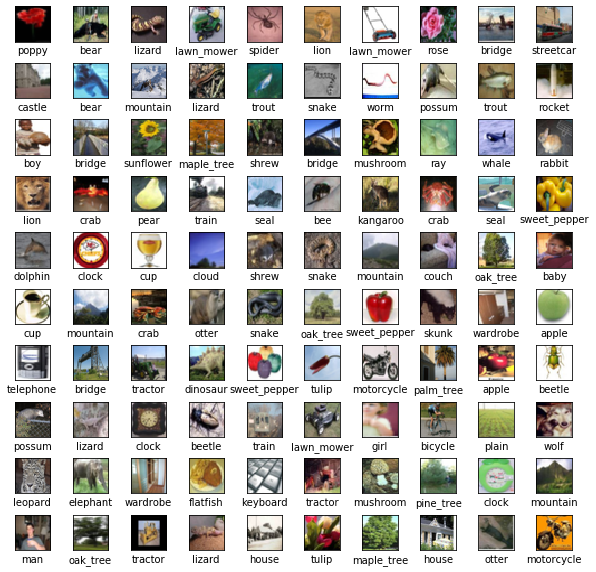

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
# reshape dense array to channel specific dimensions
h,w,ch = (32,32,3)
X_train_cifar_img = X_train_cifar.reshape(X_train_cifar.shape[0], ch, h, w).transpose(0, 2, 3, 1)
# plot mnist dataset partitions
label_idxs = list(map(str, np.unique(y_train_cifar)))
hcplt.plot_image_as_subplot(X_train_cifar_img, y_train_cifar, label_names_cifar)
plt.subplots_adjust(wspace=0.6, hspace=0.6)
# save image
plt.savefig(exports_dir/"cifar100.png", dpi=500)